In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

transactions_df = pd.read_csv(r'C:\Users\SIVABALAJI S\Desktop\ZEOTAP_Data\Transactions.csv')
products_df = pd.read_csv(r'C:\Users\SIVABALAJI S\Desktop\ZEOTAP_Data\Products (2).csv')
customers_df = pd.read_csv(r'C:\Users\SIVABALAJI S\Desktop\ZEOTAP_Data\Customers.csv')

In [3]:

print("Transactions Dataset:")
print(transactions_df.head())
print("\nProducts Dataset:")
print(products_df.head())
print("\nCustomers Dataset:")
print(customers_df.head())

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Customers Dataset:
  CustomerID        

In [4]:

merged_df = transactions_df.merge(customers_df, on="CustomerID", how="left")

In [5]:
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
latest_transaction_date = merged_df['TransactionDate'].max()

In [6]:

customer_features = merged_df.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionFrequency=('TransactionID', 'count'),
    Recency=('TransactionDate', lambda x: (latest_transaction_date - x.max()).days)
).reset_index()

In [7]:

customer_features = customer_features.merge(customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')



In [8]:

customer_features['RegionEncoded'] = customer_features['Region'].astype('category').cat.codes



In [9]:

from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpending', 'TransactionFrequency', 'Recency', 'RegionEncoded']])



In [11]:

print("Customer Features for Clustering:")
print(customer_features.head())


Customer Features for Clustering:
  CustomerID  TotalSpending  TransactionFrequency  Recency         Region  \
0      C0001        3354.52                     5       55  South America   
1      C0002        1862.74                     4       25           Asia   
2      C0003        2725.38                     4      125  South America   
3      C0004        5354.88                     8        4  South America   
4      C0005        2034.24                     3       54           Asia   

   RegionEncoded  
0              3  
1              0  
2              3  
3              3  
4              0  


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt



In [13]:

cluster_range = range(2, 11)
db_scores = []
models = {}

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db_index)
    models[k] = kmeans


optimal_k = cluster_range[db_scores.index(min(db_scores))]
optimal_model = models[optimal_k]

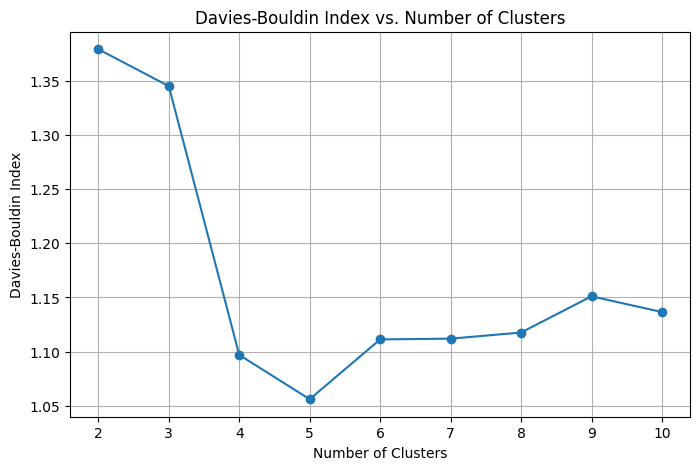

(5, 1.0560199188222819)

In [14]:

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


optimal_k, min(db_scores)


In [15]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
cluster_labels = optimal_model.labels_




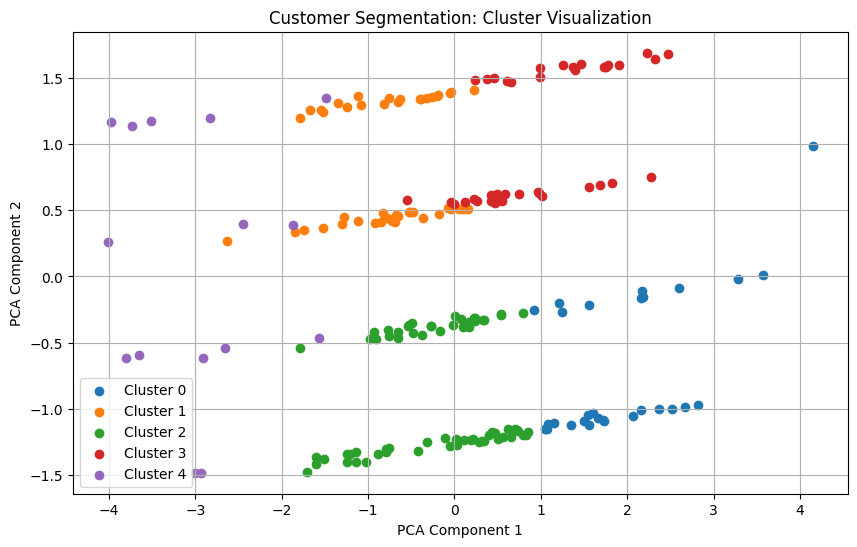

In [16]:

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_points = reduced_features[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Customer Segmentation: Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()